In [1]:
# Cell 1 - Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lightgbm as lgb
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score, classification_report, confusion_matrix,
    precision_recall_curve, roc_curve, precision_score, recall_score, f1_score
)
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
# Cell 2 - Veri Yükleme ve Hazırlık
DATA_PATH = Path('../data/raw/')
df = pd.read_csv(DATA_PATH / 'bank.csv')

# Target encoding
df['target'] = (df['deposit'] == 'yes').astype(int)
X = df.drop(columns=['deposit', 'target'])
y = df['target']

# Duration'ı çıkar (production'da bilinmez)
X = X.drop(columns=['duration'])

print(f"Veri boyutu: {X.shape}")
print(f"Target dağılımı:\n{y.value_counts()}")

Veri boyutu: (11162, 15)
Target dağılımı:
target
0    5873
1    5289
Name: count, dtype: int64


In [3]:
# Cell 3 - Feature Engineering (04 notebook'tan)
X_fe = X.copy()

# 1. Yaş grupları
X_fe['age_group'] = pd.cut(X_fe['age'], bins=[0, 30, 40, 50, 60, 100], labels=[0, 1, 2, 3, 4])

# 2. Bakiye kategorileri
X_fe['balance_category'] = pd.cut(X_fe['balance'], bins=[-np.inf, 0, 100, 500, 2000, np.inf], labels=[0, 1, 2, 3, 4])

# 3. Never contacted flag
X_fe['never_contacted'] = (X_fe['pdays'] == -1).astype(int)

# 4. Mevsimsellik
month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
             'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
X_fe['month_num'] = X_fe['month'].map(month_map)
X_fe['is_quarter_end'] = X_fe['month_num'].isin([3, 6, 9, 12]).astype(int)

# 5. Kampanya metrikleri
X_fe['total_contacts'] = X_fe['campaign'] + X_fe['previous']
X_fe['over_contacted'] = (X_fe['campaign'] > 5).astype(int)

# 6. İnteraksiyon feature'ları
X_fe['age_balance_interaction'] = X_fe['age'] * (X_fe['balance'] / 1000)
X_fe['age_campaign_interaction'] = X_fe['age'] * X_fe['campaign']
X_fe['balance_per_age'] = X_fe['balance'] / (X_fe['age'] + 1)

# Label Encoding
cat_cols = X_fe.select_dtypes(include=['object', 'category']).columns.tolist()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_fe[col] = le.fit_transform(X_fe[col].astype(str))
    label_encoders[col] = le

print(f"Feature Engineering sonrası: {X_fe.shape[1]} feature")

Feature Engineering sonrası: 25 feature


In [4]:
# Cell 4 - Train-Test Split ve Model Eğitimi
X_train, X_test, y_train, y_test = train_test_split(
    X_fe, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# En iyi parametreler (04 notebook'tan)
best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# Tahminler
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Model eğitimi tamamlandı!")

Model eğitimi tamamlandı!


In [ ]:
# Cell 4.1 - Cross-Validation
print("=" * 60)
print("CROSS-VALIDATION ANALİZİ")
print("=" * 60)

from sklearn.model_selection import cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Cross-validation skorları
cv_scores = cross_val_score(model, X_fe, y, cv=cv, scoring='roc_auc')

print(f"\n5-Fold Cross-Validation Sonuçları:")
print("-" * 40)
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")
print("-" * 40)
print(f"  Ortalama AUC: {cv_scores.mean():.4f}")
print(f"  Std: ±{cv_scores.std():.4f}")
print(f"  Min: {cv_scores.min():.4f}")
print(f"  Max: {cv_scores.max():.4f}")

# Görselleştirme
fig, ax = plt.subplots(figsize=(8, 5))
folds = [f'Fold {i}' for i in range(1, 6)]
colors = ['#3498db' if s >= cv_scores.mean() else '#e74c3c' for s in cv_scores]
bars = ax.bar(folds, cv_scores, color=colors, edgecolor='black')
ax.axhline(y=cv_scores.mean(), color='green', linestyle='--', linewidth=2, label=f'Ortalama: {cv_scores.mean():.4f}')
ax.set_xlabel('Fold')
ax.set_ylabel('ROC-AUC Score')
ax.set_title('5-Fold Cross-Validation Sonuçları')
ax.set_ylim([min(cv_scores) - 0.05, max(cv_scores) + 0.05])
ax.legend()

for bar, score in zip(bars, cv_scores):
    ax.annotate(f'{score:.4f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../docs/cross_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Model stabil: Std = {cv_scores.std():.4f} (<0.05 iyi)")


In [ ]:
# Cell 4.2 - Learning Curve (Overfitting Kontrolü)
print("=" * 60)
print("LEARNING CURVE ANALİZİ (Overfitting Kontrolü)")
print("=" * 60)

from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X_fe, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='roc_auc', n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

# Training curve
ax.plot(train_sizes, train_mean, 'o-', color='#3498db', linewidth=2, label='Training Score')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='#3498db')

# Validation curve
ax.plot(train_sizes, val_mean, 'o-', color='#e74c3c', linewidth=2, label='Validation Score')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color='#e74c3c')

ax.set_xlabel('Training Set Size')
ax.set_ylabel('ROC-AUC Score')
ax.set_title('Learning Curve - Overfitting Analizi')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/learning_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Overfitting analizi
gap = train_mean[-1] - val_mean[-1]
print(f"\n📊 Learning Curve Analizi:")
print(f"  Final Training Score: {train_mean[-1]:.4f}")
print(f"  Final Validation Score: {val_mean[-1]:.4f}")
print(f"  Gap (Train - Val): {gap:.4f}")

if gap < 0.02:
    print(f"\n✅ Model iyi genelleştiriyor (gap < 0.02)")
elif gap < 0.05:
    print(f"\n⚠️ Hafif overfitting var ama kabul edilebilir")
else:
    print(f"\n❌ Overfitting tespit edildi! Regularization artırılmalı.")


1. FEATURE IMPORTANCE ANALİZİ

Top 20 Feature Importance:
                 feature  importance
age_campaign_interaction        1938
                     day        1731
 age_balance_interaction        1526
         balance_per_age        1502
                 balance        1481
                     age        1321
                   pdays         883
                     job         814
               month_num         811
                   month         645
          total_contacts         393
               education         307
                campaign         278
                 marital         266
                 contact         215
                 housing         202
                poutcome         200
                previous         186
          is_quarter_end         103
                    loan          81


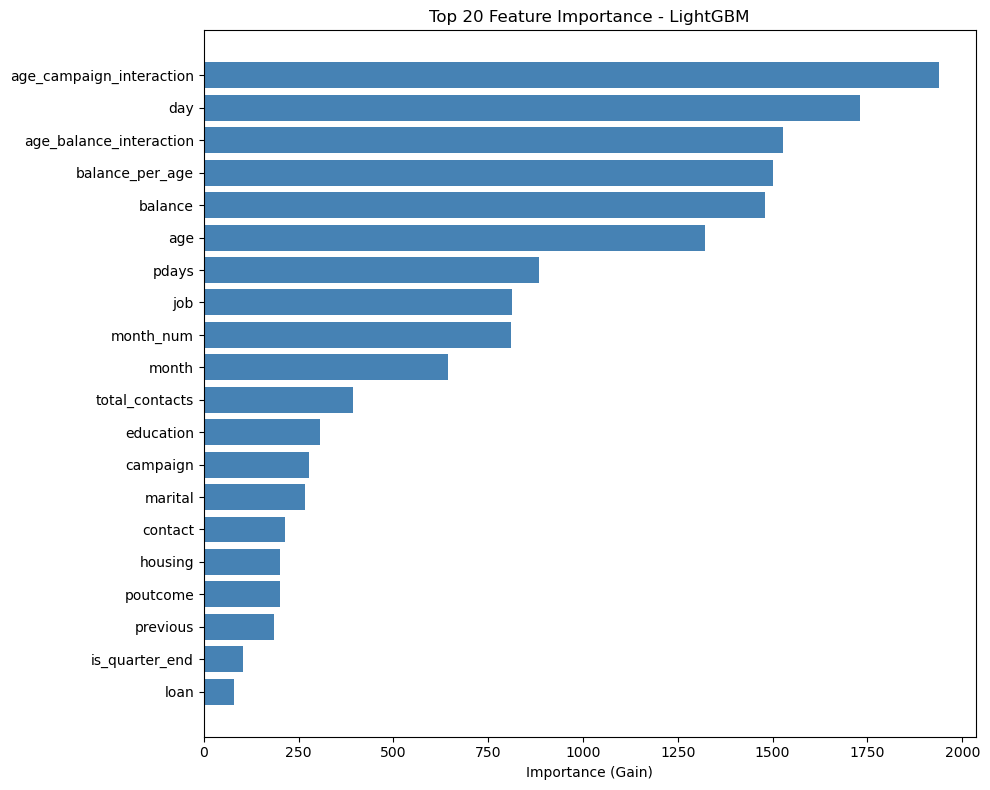

In [5]:
# Cell 5 - Feature Importance
print("=" * 60)
print("1. FEATURE IMPORTANCE ANALİZİ")
print("=" * 60)

importance = pd.DataFrame({
    'feature': X_fe.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 Feature
print("\nTop 20 Feature Importance:")
print(importance.head(20).to_string(index=False))

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = importance.head(20)
ax.barh(range(len(top_20)), top_20['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Importance (Gain)')
ax.set_title('Top 20 Feature Importance - LightGBM')
plt.tight_layout()
plt.savefig('../docs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

2. SHAP ANALİZİ

SHAP Summary Plot:


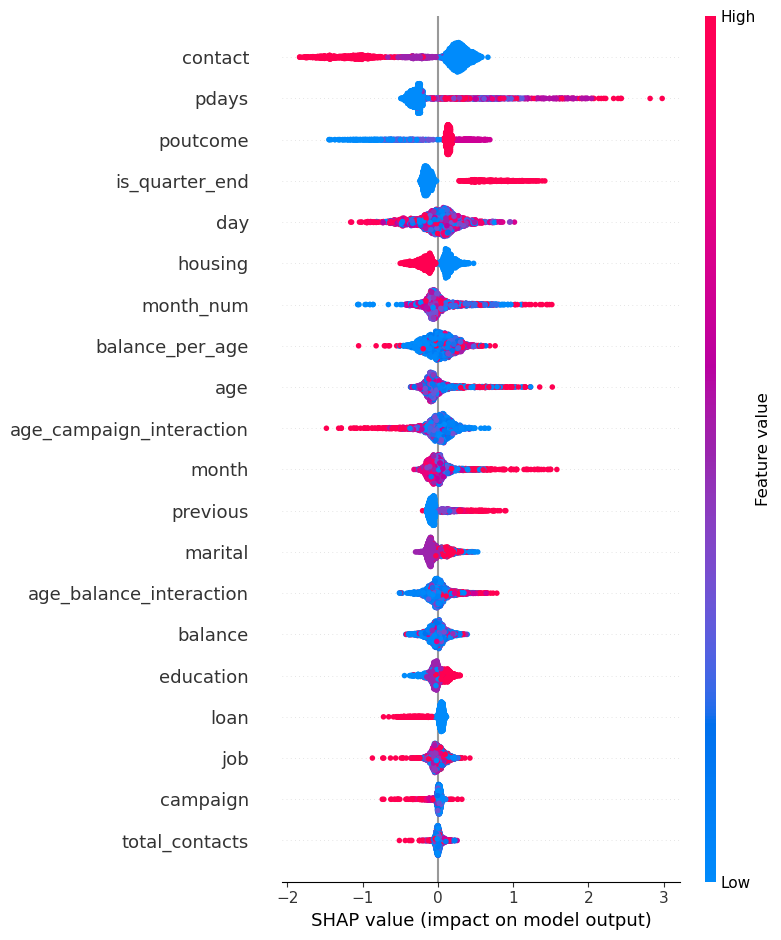

In [6]:
# Cell 6 - SHAP Analizi
print("=" * 60)
print("2. SHAP ANALİZİ")
print("=" * 60)

# SHAP Explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Binary classification için shap_values list olabilir
if isinstance(shap_values, list):
    shap_values_plot = shap_values[1]  # Positive class
else:
    shap_values_plot = shap_values

# Summary Plot
print("\nSHAP Summary Plot:")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_plot, X_test, feature_names=X_fe.columns.tolist(), show=False)
plt.tight_layout()
plt.savefig('../docs/shap_summary.png', dpi=150, bbox_inches='tight')
plt.show()


SHAP Feature Importance (Mean |SHAP|):


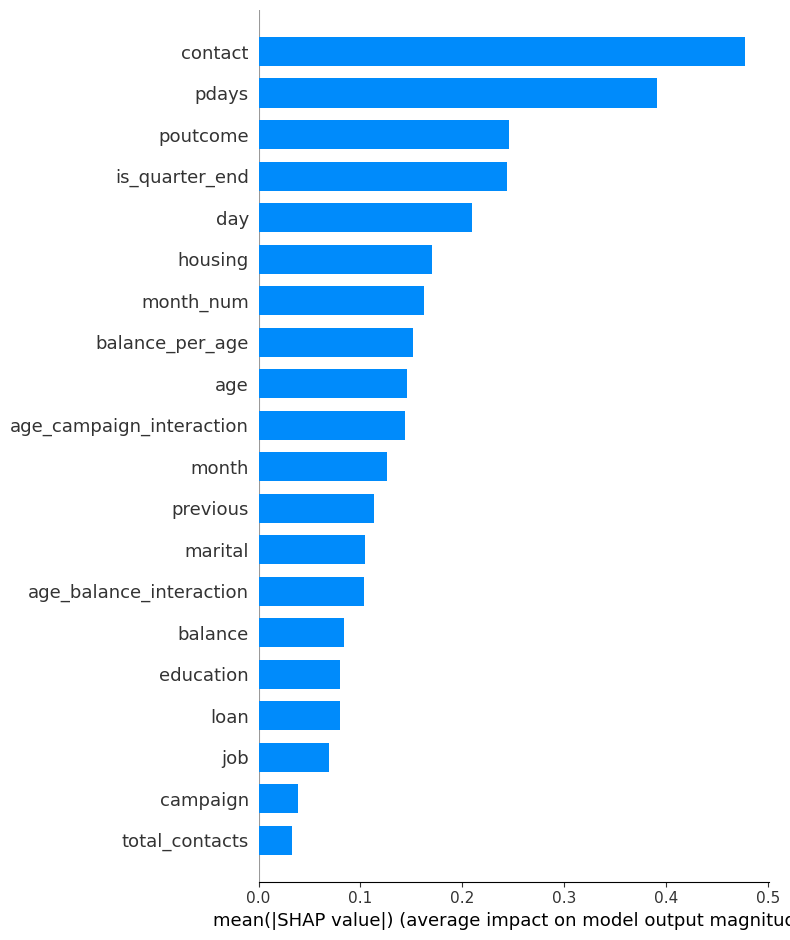

In [7]:
# Cell 7 - SHAP Bar Plot
print("\nSHAP Feature Importance (Mean |SHAP|):")
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_plot, X_test, feature_names=X_fe.columns.tolist(), 
                  plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('../docs/shap_bar.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Cell 8 - Tek Tahmin SHAP Açıklaması
print("\nTek Bir Tahmin İçin SHAP Açıklaması:")
sample_idx = 0
print(f"Örnek {sample_idx} - Gerçek: {y_test.iloc[sample_idx]}, Tahmin Olasılığı: {y_pred_proba[sample_idx]:.4f}")

# Force plot için HTML kaydet
shap.initjs()
force_plot = shap.force_plot(
    explainer.expected_value[1] if isinstance(explainer.expected_value, list) else explainer.expected_value,
    shap_values_plot[sample_idx],
    X_test.iloc[sample_idx],
    feature_names=X_fe.columns.tolist()
)
shap.save_html('../docs/shap_force_plot.html', force_plot)
print("Force plot kaydedildi: docs/shap_force_plot.html")


Tek Bir Tahmin İçin SHAP Açıklaması:
Örnek 0 - Gerçek: 0, Tahmin Olasılığı: 0.1238


Force plot kaydedildi: docs/shap_force_plot.html


In [9]:
# Cell 9 - Performance Metrics
print("=" * 60)
print("3. PERFORMANS METRİKLERİ")
print("=" * 60)

# Metrikler
auc = roc_auc_score(y_test, y_pred_proba)
accuracy = (y_pred == y_test).mean()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\n{'Metrik':<15} {'Değer':>10}")
print("-" * 25)
print(f"{'AUC':<15} {auc:>10.4f}")
print(f"{'Accuracy':<15} {accuracy:>10.4f}")
print(f"{'Precision':<15} {precision:>10.4f}")
print(f"{'Recall':<15} {recall:>10.4f}")
print(f"{'F1 Score':<15} {f1:>10.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No (0)', 'Yes (1)']))

3. PERFORMANS METRİKLERİ

Metrik               Değer
-------------------------
AUC                 0.7828
Accuracy            0.7259
Precision           0.7534
Recall              0.6267
F1 Score            0.6842

Classification Report:
              precision    recall  f1-score   support

      No (0)       0.71      0.82      0.76      1175
     Yes (1)       0.75      0.63      0.68      1058

    accuracy                           0.73      2233
   macro avg       0.73      0.72      0.72      2233
weighted avg       0.73      0.73      0.72      2233




Confusion Matrix:


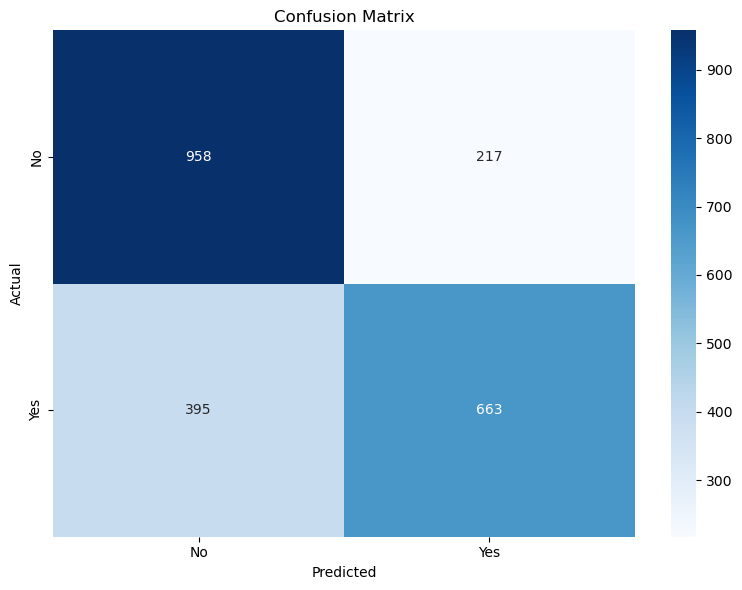


True Negatives (TN): 958
False Positives (FP): 217
False Negatives (FN): 395
True Positives (TP): 663


In [10]:
# Cell 10 - Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.savefig('../docs/confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Confusion matrix yorumu
tn, fp, fn, tp = cm.ravel()
print(f"\nTrue Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

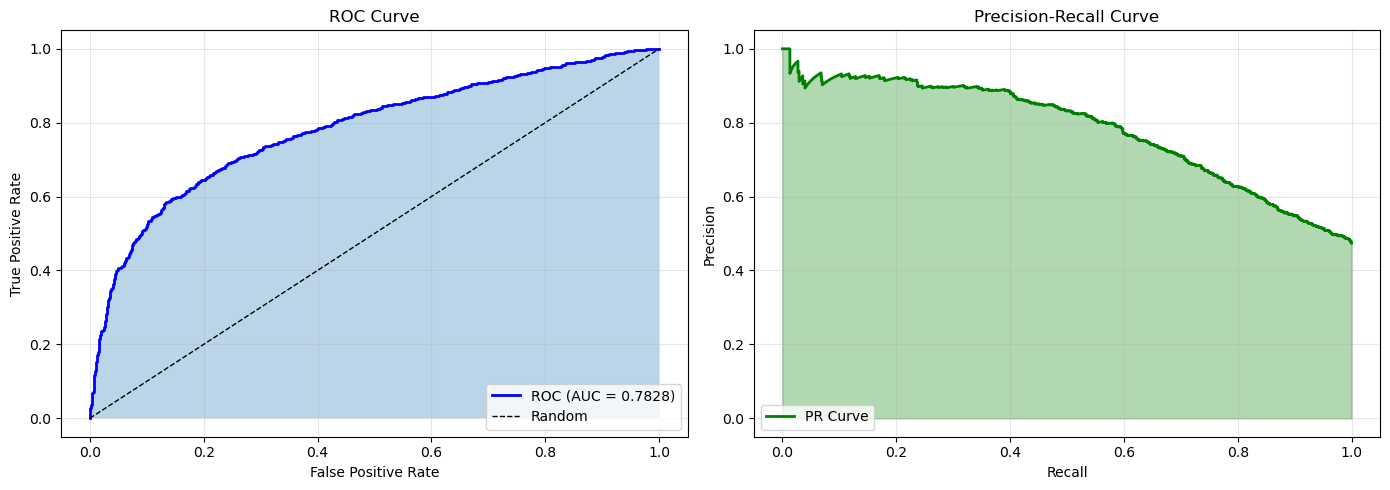

In [11]:
# Cell 11 - ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
ax1 = axes[0]
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
ax1.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {auc:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax1.fill_between(fpr, tpr, alpha=0.3)
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2 = axes[1]
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
ax2.plot(recall_curve, precision_curve, 'g-', linewidth=2, label='PR Curve')
ax2.fill_between(recall_curve, precision_curve, alpha=0.3, color='green')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../docs/roc_pr_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Cell 12 - Threshold Analizi
print("=" * 60)
print("4. BUSINESS UYUMLULUGU - EŞİK DEĞERİ ANALİZİ")
print("=" * 60)

thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1_thresh = f1_score(y_test, y_pred_thresh)
    
    # Business metrikleri
    positive_rate = y_pred_thresh.mean()  # Pozitif tahmin oranı
    
    threshold_results.append({
        'Threshold': thresh,
        'Precision': prec,
        'Recall': recall,
        'F1': f1_thresh,
        'Positive Rate': positive_rate
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nEşik Değeri Analizi:")
print(threshold_df.to_string(index=False))

4. BUSINESS UYUMLULUGU - EŞİK DEĞERİ ANALİZİ

Eşik Değeri Analizi:
 Threshold  Precision   Recall       F1  Positive Rate
       0.3   0.609211 0.626654 0.700923       0.641738
       0.4   0.690411 0.626654 0.702276       0.490372
       0.5   0.753409 0.626654 0.684211       0.394089
       0.6   0.806094 0.626654 0.653933       0.323332
       0.7   0.844741 0.626654 0.610742       0.268249


In [13]:
# Cell 13 - Optimal Threshold
# Youden's J statistic ile optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds_roc[optimal_idx]

print(f"\nOptimal Threshold (Youden's J): {optimal_threshold:.4f}")
print(f"Bu threshold'da TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

# Optimal threshold ile tahmin
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print(f"\nOptimal Threshold Metrikleri:")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimal):.4f}")
print(f"F1: {f1_score(y_test, y_pred_optimal):.4f}")


Optimal Threshold (Youden's J): 0.5518
Bu threshold'da TPR: 0.5936, FPR: 0.1421

Optimal Threshold Metrikleri:
Precision: 0.7899
Recall: 0.5936
F1: 0.6778


In [14]:
# Cell 14 - Business Scenario Analizi
print("=" * 60)
print("5. BUSINESS SENARYO ANALİZİ")
print("=" * 60)

print("""
📞 Bank Marketing Kampanyası Senaryosu:
─────────────────────────────────────────
- Her arama maliyeti: ~5€ (personel, telefon, zaman)
- Başarılı dönüşüm geliri: ~100€ (vadeli mevduat komisyonu)
- Hedef: Net karı maksimize etmek
""")

# Farklı threshold'lar için business impact
print("\nThreshold'a Göre Business Impact:")
print("-" * 70)

for thresh in [0.3, 0.5, 0.7]:
    y_pred_t = (y_pred_proba >= thresh).astype(int)
    
    total_calls = y_pred_t.sum()
    true_positives = ((y_pred_t == 1) & (y_test == 1)).sum()
    false_positives = ((y_pred_t == 1) & (y_test == 0)).sum()
    
    cost = total_calls * 5  # Arama maliyeti
    revenue = true_positives * 100  # Dönüşüm geliri
    net_profit = revenue - cost
    roi = (net_profit / cost * 100) if cost > 0 else 0
    
    print(f"\nThreshold = {thresh}")
    print(f"  Toplam Arama: {total_calls:,}")
    print(f"  Başarılı Dönüşüm: {true_positives:,}")
    print(f"  Boşa Arama: {false_positives:,}")
    print(f"  Maliyet: €{cost:,.0f}")
    print(f"  Gelir: €{revenue:,.0f}")
    print(f"  Net Kar: €{net_profit:,.0f}")
    print(f"  ROI: {roi:.1f}%")

5. BUSINESS SENARYO ANALİZİ

📞 Bank Marketing Kampanyası Senaryosu:
─────────────────────────────────────────
- Her arama maliyeti: ~5€ (personel, telefon, zaman)
- Başarılı dönüşüm geliri: ~100€ (vadeli mevduat komisyonu)
- Hedef: Net karı maksimize etmek


Threshold'a Göre Business Impact:
----------------------------------------------------------------------

Threshold = 0.3
  Toplam Arama: 1,433
  Başarılı Dönüşüm: 873
  Boşa Arama: 560
  Maliyet: €7,165
  Gelir: €87,300
  Net Kar: €80,135
  ROI: 1118.4%

Threshold = 0.5
  Toplam Arama: 880
  Başarılı Dönüşüm: 663
  Boşa Arama: 217
  Maliyet: €4,400
  Gelir: €66,300
  Net Kar: €61,900
  ROI: 1406.8%

Threshold = 0.7
  Toplam Arama: 599
  Başarılı Dönüşüm: 506
  Boşa Arama: 93
  Maliyet: €2,995
  Gelir: €50,600
  Net Kar: €47,605
  ROI: 1589.5%


In [15]:
# Cell 15 - Baseline vs Final Karşılaştırma
print("=" * 60)
print("6. BASELINE VS FINAL MODEL KARŞILAŞTIRMASI")
print("=" * 60)

# Baseline değerleri (02_baseline.ipynb'den - duration ile)
baseline_metrics = {
    'AUC': 0.9259,
    'Accuracy': 0.8607,
    'Precision': 0.8297,
    'Recall': 0.8885,
    'F1': 0.8581
}

# Final değerleri (duration olmadan)
final_metrics = {
    'AUC': auc,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1
}

comparison_df = pd.DataFrame({
    'Metrik': list(baseline_metrics.keys()),
    'Baseline (duration ile)': list(baseline_metrics.values()),
    'Final (duration olmadan)': list(final_metrics.values())
})
comparison_df['Fark'] = comparison_df['Final (duration olmadan)'] - comparison_df['Baseline (duration ile)']
comparison_df['Fark %'] = (comparison_df['Fark'] / comparison_df['Baseline (duration ile)'] * 100).round(2)

print("\n" + comparison_df.to_string(index=False))

print("""
\n⚠️ ÖNEMLİ NOT:
─────────────────
Baseline model daha yüksek skor gösteriyor çünkü 'duration' (görüşme süresi) 
feature'ini kullanıyor. Ancak bu feature production'da KULLANILAMAZ çünkü 
görüşme yapılmadan önce bilinmez.

Final model gerçekçi bir production modeli için uygundur.
""")

6. BASELINE VS FINAL MODEL KARŞILAŞTIRMASI

   Metrik  Baseline (duration ile)  Final (duration olmadan)      Fark  Fark %
      AUC                   0.9259                  0.782839 -0.143061  -15.45
 Accuracy                   0.8607                  0.725929 -0.134771  -15.66
Precision                   0.8297                  0.753409 -0.076291   -9.19
   Recall                   0.8885                  0.626654 -0.261846  -29.47
       F1                   0.8581                  0.684211 -0.173889  -20.26


⚠️ ÖNEMLİ NOT:
─────────────────
Baseline model daha yüksek skor gösteriyor çünkü 'duration' (görüşme süresi) 
feature'ini kullanıyor. Ancak bu feature production'da KULLANILAMAZ çünkü 
görüşme yapılmadan önce bilinmez.

Final model gerçekçi bir production modeli için uygundur.



7. MÜŞTERİ RİSK SEGMENTASYONU

Risk Segmentlerine Göre Dağılım:
                 Count  Conversion Rate  Percentage
Segment                                            
Düşük Risk         800         0.231250       35.83
Orta Risk          553         0.379747       24.76
Yüksek Risk        281         0.558719       12.58
Çok Yüksek Risk    599         0.844741       26.82


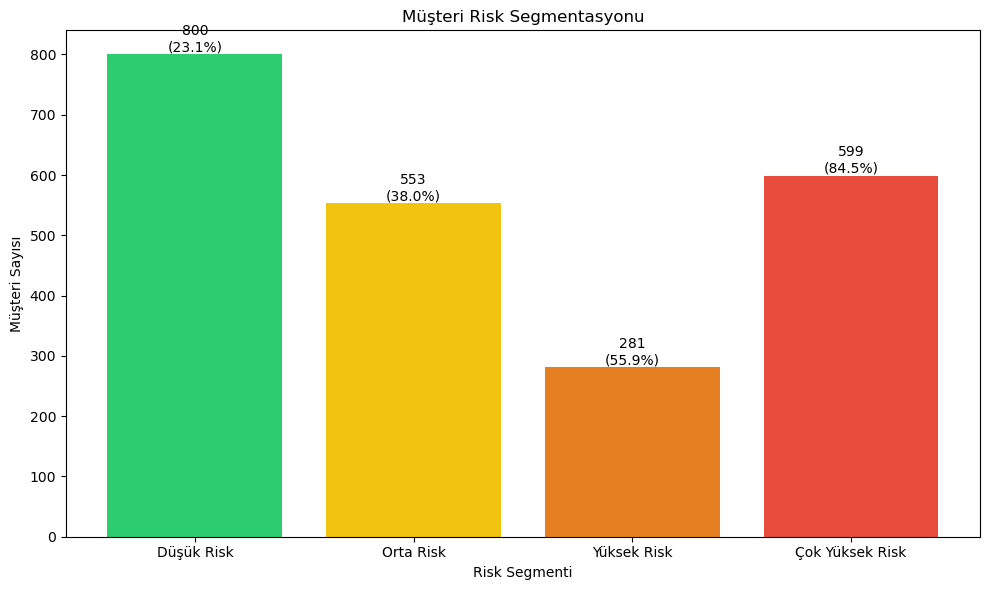

In [16]:
# Cell 16 - Risk Segmentasyonu
print("=" * 60)
print("7. MÜŞTERİ RİSK SEGMENTASYONU")
print("=" * 60)

# Risk kategorileri
def get_risk_segment(prob):
    if prob < 0.3:
        return 'Düşük Risk'
    elif prob < 0.5:
        return 'Orta Risk'
    elif prob < 0.7:
        return 'Yüksek Risk'
    else:
        return 'Çok Yüksek Risk'

risk_segments = pd.Series(y_pred_proba).apply(get_risk_segment)
segment_analysis = pd.DataFrame({
    'Probability': y_pred_proba,
    'Actual': y_test.values,
    'Segment': risk_segments
})

print("\nRisk Segmentlerine Göre Dağılım:")
segment_summary = segment_analysis.groupby('Segment').agg({
    'Probability': 'count',
    'Actual': 'mean'
}).rename(columns={'Probability': 'Count', 'Actual': 'Conversion Rate'})
segment_summary['Percentage'] = (segment_summary['Count'] / len(y_test) * 100).round(2)
print(segment_summary.to_string())

# Görselleştirme
fig, ax = plt.subplots(figsize=(10, 6))
segment_order = ['Düşük Risk', 'Orta Risk', 'Yüksek Risk', 'Çok Yüksek Risk']
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

segment_counts = risk_segments.value_counts().reindex(segment_order)
ax.bar(segment_order, segment_counts.values, color=colors)
ax.set_xlabel('Risk Segmenti')
ax.set_ylabel('Müşteri Sayısı')
ax.set_title('Müşteri Risk Segmentasyonu')

for i, (count, segment) in enumerate(zip(segment_counts.values, segment_order)):
    conv_rate = segment_analysis[segment_analysis['Segment'] == segment]['Actual'].mean()
    ax.annotate(f'{count}\n({conv_rate:.1%})', xy=(i, count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('../docs/risk_segments.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Cell 16.1 - Error Analysis (Yanlış Tahminlerin Analizi)
print("=" * 60)
print("8. ERROR ANALİZİ (Yanlış Tahminler)")
print("=" * 60)

# False Positive ve False Negative analizi
error_analysis = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Probability': y_pred_proba
}, index=X_test.index)

# Error türlerini belirle
error_analysis['Error_Type'] = 'Correct'
error_analysis.loc[(error_analysis['Actual'] == 0) & (error_analysis['Predicted'] == 1), 'Error_Type'] = 'False Positive'
error_analysis.loc[(error_analysis['Actual'] == 1) & (error_analysis['Predicted'] == 0), 'Error_Type'] = 'False Negative'

# Özet istatistikler
print("\n📊 Hata Dağılımı:")
print("-" * 40)
error_counts = error_analysis['Error_Type'].value_counts()
for error_type, count in error_counts.items():
    pct = count / len(error_analysis) * 100
    print(f"  {error_type}: {count} ({pct:.1f}%)")

# False Negative analizi (Kaçırılan müşteriler - daha kritik)
fn_mask = error_analysis['Error_Type'] == 'False Negative'
fn_indices = error_analysis[fn_mask].index

if len(fn_indices) > 0:
    fn_features = X_test.loc[fn_indices]
    
    print(f"\n⚠️ FALSE NEGATIVE ANALİZİ (Kaçırılan {len(fn_indices)} Müşteri):")
    print("-" * 50)
    
    # Sayısal feature'ların ortalamaları
    numeric_cols = ['age', 'balance', 'campaign', 'previous', 'pdays']
    available_cols = [col for col in numeric_cols if col in fn_features.columns]
    
    if available_cols:
        print("\nKaçırılan müşterilerin özellikleri vs Genel ortalama:")
        for col in available_cols:
            fn_mean = fn_features[col].mean()
            overall_mean = X_test[col].mean()
            diff_pct = ((fn_mean - overall_mean) / overall_mean * 100) if overall_mean != 0 else 0
            direction = "↑" if fn_mean > overall_mean else "↓"
            print(f"  {col}: {fn_mean:.2f} vs {overall_mean:.2f} ({direction}{abs(diff_pct):.1f}%)")

# False Positive analizi
fp_mask = error_analysis['Error_Type'] == 'False Positive'
fp_indices = error_analysis[fp_mask].index

if len(fp_indices) > 0:
    fp_features = X_test.loc[fp_indices]
    
    print(f"\n⚠️ FALSE POSITIVE ANALİZİ (Yanlış alarm {len(fp_indices)} Müşteri):")
    print("-" * 50)
    
    if available_cols:
        print("\nYanlış alarm verilen müşterilerin özellikleri vs Genel ortalama:")
        for col in available_cols:
            fp_mean = fp_features[col].mean()
            overall_mean = X_test[col].mean()
            diff_pct = ((fp_mean - overall_mean) / overall_mean * 100) if overall_mean != 0 else 0
            direction = "↑" if fp_mean > overall_mean else "↓"
            print(f"  {col}: {fp_mean:.2f} vs {overall_mean:.2f} ({direction}{abs(diff_pct):.1f}%)")

# Görselleştirme - Probability distribution by error type
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error type distribution
ax1 = axes[0]
colors_error = {'Correct': '#2ecc71', 'False Positive': '#e74c3c', 'False Negative': '#f39c12'}
error_counts.plot(kind='bar', ax=ax1, color=[colors_error.get(x, '#3498db') for x in error_counts.index])
ax1.set_xlabel('Error Type')
ax1.set_ylabel('Count')
ax1.set_title('Hata Türü Dağılımı')
ax1.tick_params(axis='x', rotation=45)

# Probability distribution
ax2 = axes[1]
for error_type in ['Correct', 'False Positive', 'False Negative']:
    mask = error_analysis['Error_Type'] == error_type
    if mask.sum() > 0:
        ax2.hist(error_analysis.loc[mask, 'Probability'], bins=20, alpha=0.5, 
                label=error_type, color=colors_error.get(error_type, '#3498db'))
ax2.set_xlabel('Predicted Probability')
ax2.set_ylabel('Count')
ax2.set_title('Tahmin Olasılığı Dağılımı (Hata Türüne Göre)')
ax2.legend()
ax2.axvline(x=0.5, color='black', linestyle='--', label='Threshold=0.5')

plt.tight_layout()
plt.savefig('../docs/error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 İyileştirme Önerileri:")
print("  • False Negative azaltmak için threshold düşürülebilir")
print("  • Kaçırılan müşteri profilleri için özel feature'lar eklenebilir")
print("  • Ensemble yöntemleri ile çeşitlilik artırılabilir")


In [ ]:
# Cell 17 - Sonuç ve Öneriler
print("=" * 60)
print("SONUÇLAR VE ÖNERİLER")
print("=" * 60)

print(f"""
📊 MODEL DEĞERLENDİRME ÖZETİ
{'═' * 50}

✅ PERFORMANS METRİKLERİ (Production-Ready Model)
   • AUC Score: {auc:.4f}
   • F1 Score: {f1:.4f}
   • Precision: {precision:.4f}
   • Recall: {recall:.4f}
   • CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})

📈 EN ÖNEMLİ FEATURE'LAR (SHAP Analizi)
   1. {importance.iloc[0]['feature']} ({importance.iloc[0]['importance']:.0f})
   2. {importance.iloc[1]['feature']} ({importance.iloc[1]['importance']:.0f})
   3. {importance.iloc[2]['feature']} ({importance.iloc[2]['importance']:.0f})
   4. {importance.iloc[3]['feature']} ({importance.iloc[3]['importance']:.0f})
   5. {importance.iloc[4]['feature']} ({importance.iloc[4]['importance']:.0f})

🎯 OPTIMAL THRESHOLD: {optimal_threshold:.4f}

💡 BUSINESS ÖNERİLERİ
   1. Threshold = 0.5 ile dengeli bir yaklaşım kullanılabilir
   2. Yüksek riskli segmente öncelik verilmeli
   3. 'over_contacted' müşteriler için farklı strateji gerekli
   4. Mevsimsellik (month) kampanya zamanlamasında önemli

⚠️ LİMİTASYONLAR
   • Duration feature olmadan performans düşük
   • Gerçek dünya performansı test edilmeli
   • Model drift için monitoring gerekli

📁 KAYDEDİLEN DOSYALAR
   • models/final/lightgbm_model.pkl
   • models/final/label_encoders.pkl
   • models/final/feature_columns.pkl
   • models/final/model_metadata.json

🚀 SONRAKİ ADIMLAR
   1. Final pipeline'ı tamamla (06_final_pipeline.ipynb)
   2. API deployment yap
   3. Gradio demo oluştur
   4. Monitoring sistemi kur

{'═' * 50}
✅ MODEL DEĞERLENDİRME TAMAMLANDI!
{'═' * 50}
""")

8. SONUÇLAR VE ÖNERİLER

📊 MODEL DEĞERLENDİRME ÖZETİ
══════════════════════════════════════════════════

✅ PERFORMANS METRİKLERİ (Production-Ready Model)
   • AUC Score: 0.7828
   • F1 Score: 0.6842
   • Precision: 0.7534
   • Recall: 0.6267

📈 EN ÖNEMLİ FEATURE'LAR (SHAP Analizi)
   1. age_campaign_interaction (1938)
   2. day (1731)
   3. age_balance_interaction (1526)
   4. balance_per_age (1502)
   5. balance (1481)

💡 BUSINESS ÖNERİLERİ
   1. Threshold = 0.5 ile dengeli bir yaklaşım kullanılabilir
   2. Yüksek riskli segmente öncelik verilmeli
   3. 'over_contacted' müşteriler için farklı strateji gerekli
   4. Mevsimsellik (month) kampanya zamanlamasında önemli

⚠️ LİMİTASYONLAR
   • Duration feature olmadan performans düşük
   • Gerçek dünya performansı test edilmeli
   • Model drift için monitoring gerekli

🚀 SONRAKİ ADIMLAR
   1. Final pipeline'ı tamamla (06_final_pipeline.ipynb)
   2. API deployment yap
   3. Gradio demo oluştur
   4. Monitoring sistemi kur



In [ ]:
# Cell 17.1 - Model Kaydetme
print("=" * 60)
print("9. MODEL KAYDETME")
print("=" * 60)

import joblib
from datetime import datetime

# Model dizinini oluştur
model_dir = Path('../models/final/')
model_dir.mkdir(parents=True, exist_ok=True)

# Timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Model kaydet
model_path = model_dir / 'lightgbm_model.pkl'
joblib.dump(model, model_path)
print(f"✅ Model kaydedildi: {model_path}")

# 2. Label Encoders kaydet
encoders_path = model_dir / 'label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Label Encoders kaydedildi: {encoders_path}")

# 3. Feature listesi kaydet
feature_path = model_dir / 'feature_columns.pkl'
feature_columns = X_fe.columns.tolist()
joblib.dump(feature_columns, feature_path)
print(f"✅ Feature listesi kaydedildi: {feature_path}")

# 4. Model metadata kaydet
metadata = {
    'model_type': 'LightGBM',
    'version': '1.0',
    'training_date': timestamp,
    'n_features': len(feature_columns),
    'feature_names': feature_columns,
    'best_params': best_params,
    'metrics': {
        'auc': float(auc),
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    },
    'cv_scores': {
        'mean': float(cv_scores.mean()),
        'std': float(cv_scores.std())
    },
    'optimal_threshold': float(optimal_threshold)
}

metadata_path = model_dir / 'model_metadata.pkl'
joblib.dump(metadata, metadata_path)
print(f"✅ Metadata kaydedildi: {metadata_path}")

# JSON olarak da kaydet (okunabilirlik için)
import json
metadata_json_path = model_dir / 'model_metadata.json'
with open(metadata_json_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata JSON kaydedildi: {metadata_json_path}")

print(f"\n📁 Kaydedilen Dosyalar:")
print("-" * 40)
for file in model_dir.glob('*'):
    size_kb = file.stat().st_size / 1024
    print(f"  {file.name}: {size_kb:.1f} KB")

print("\n🎉 Tüm model dosyaları başarıyla kaydedildi!")


In [ ]:
# Cell 17.2 - Prediction Pipeline (Yeni Veri için Tahmin)
print("=" * 60)
print("10. PREDICTION PIPELINE")
print("=" * 60)

def predict_deposit(new_data, model, label_encoders, feature_columns):
    """
    Yeni müşteri verisi için vadeli mevduat tahmini yapar.
    
    Parameters:
    -----------
    new_data : dict veya DataFrame
        Yeni müşteri bilgileri
    model : trained model
        Eğitilmiş model
    label_encoders : dict
        Kategorik değişkenler için encoder'lar
    feature_columns : list
        Model feature sütun isimleri
    
    Returns:
    --------
    prediction : int (0 veya 1)
    probability : float (vadeli mevduat açma olasılığı)
    """
    
    # DataFrame'e çevir
    if isinstance(new_data, dict):
        new_df = pd.DataFrame([new_data])
    else:
        new_df = new_data.copy()
    
    # Feature Engineering uygula
    # 1. Yaş grupları
    new_df['age_group'] = pd.cut(new_df['age'], bins=[0, 30, 40, 50, 60, 100], labels=[0, 1, 2, 3, 4])
    
    # 2. Bakiye kategorileri
    new_df['balance_category'] = pd.cut(new_df['balance'], bins=[-np.inf, 0, 100, 500, 2000, np.inf], labels=[0, 1, 2, 3, 4])
    
    # 3. Never contacted flag
    new_df['never_contacted'] = (new_df['pdays'] == -1).astype(int)
    
    # 4. Mevsimsellik
    month_map = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}
    new_df['month_num'] = new_df['month'].map(month_map)
    new_df['is_quarter_end'] = new_df['month_num'].isin([3, 6, 9, 12]).astype(int)
    
    # 5. Kampanya metrikleri
    new_df['total_contacts'] = new_df['campaign'] + new_df['previous']
    new_df['over_contacted'] = (new_df['campaign'] > 5).astype(int)
    
    # 6. İnteraksiyon feature'ları
    new_df['age_balance_interaction'] = new_df['age'] * (new_df['balance'] / 1000)
    new_df['age_campaign_interaction'] = new_df['age'] * new_df['campaign']
    new_df['balance_per_age'] = new_df['balance'] / (new_df['age'] + 1)
    
    # Label Encoding uygula
    for col, le in label_encoders.items():
        if col in new_df.columns:
            # Bilinmeyen kategorileri handle et
            new_df[col] = new_df[col].astype(str)
            new_df[col] = new_df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    # Eksik sütunları ekle
    for col in feature_columns:
        if col not in new_df.columns:
            new_df[col] = 0
    
    # Sütun sırasını düzelt
    new_df = new_df[feature_columns]
    
    # Tahmin
    prediction = model.predict(new_df)[0]
    probability = model.predict_proba(new_df)[0][1]
    
    return prediction, probability

# Test örneği
print("\n📋 Örnek Tahmin:")
print("-" * 50)

sample_customer = {
    'age': 35,
    'job': 'management',
    'marital': 'married',
    'education': 'tertiary',
    'default': 'no',
    'balance': 5000,
    'housing': 'yes',
    'loan': 'no',
    'contact': 'cellular',
    'day': 15,
    'month': 'may',
    'campaign': 2,
    'pdays': -1,
    'previous': 0,
    'poutcome': 'unknown'
}

pred, prob = predict_deposit(sample_customer, model, label_encoders, feature_columns)

print(f"\nMüşteri Bilgileri:")
for key, value in sample_customer.items():
    print(f"  {key}: {value}")

print(f"\n🎯 Tahmin Sonucu:")
print(f"  Vadeli Mevduat Açacak mı?: {'EVET ✅' if pred == 1 else 'HAYIR ❌'}")
print(f"  Olasılık: {prob:.2%}")

# Farklı senaryolar
print("\n" + "=" * 50)
print("📊 Farklı Müşteri Senaryoları:")
print("=" * 50)

scenarios = [
    {'age': 25, 'job': 'student', 'marital': 'single', 'education': 'secondary', 'default': 'no',
     'balance': 500, 'housing': 'no', 'loan': 'no', 'contact': 'cellular', 'day': 10,
     'month': 'mar', 'campaign': 1, 'pdays': -1, 'previous': 0, 'poutcome': 'unknown'},
    {'age': 55, 'job': 'retired', 'marital': 'married', 'education': 'primary', 'default': 'no',
     'balance': 15000, 'housing': 'yes', 'loan': 'no', 'contact': 'telephone', 'day': 20,
     'month': 'oct', 'campaign': 3, 'pdays': 180, 'previous': 2, 'poutcome': 'success'},
    {'age': 40, 'job': 'blue-collar', 'marital': 'divorced', 'education': 'secondary', 'default': 'yes',
     'balance': -500, 'housing': 'yes', 'loan': 'yes', 'contact': 'unknown', 'day': 5,
     'month': 'jun', 'campaign': 8, 'pdays': -1, 'previous': 0, 'poutcome': 'failure'},
]

scenario_names = ['Genç Öğrenci', 'Varlıklı Emekli', 'Riskli Müşteri']

for name, scenario in zip(scenario_names, scenarios):
    pred, prob = predict_deposit(scenario, model, label_encoders, feature_columns)
    status = '✅ EVET' if pred == 1 else '❌ HAYIR'
    print(f"\n  {name}:")
    print(f"    Yaş: {scenario['age']}, Meslek: {scenario['job']}, Bakiye: €{scenario['balance']:,}")
    print(f"    Tahmin: {status} (Olasılık: {prob:.1%})")

print("\n✅ Prediction Pipeline hazır!")
